# American Sign Language (ASL) Image Recognition

## Introduction

## Loading in dataset

In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile  
from sklearn.datasets import load_files
from keras.utils import np_utils
from keras.preprocessing import image                  
from tqdm import tqdm

# For compiling model
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D

# For transfer learning
import scipy
import keras.applications.vgg16 as vgg16
import keras.applications.vgg19 as vgg19
import keras.applications.resnet50 as resnet50

# For confusion matrix calculation/visualization
import tensorflow as tf
import seaborn as sn
import pandas as pd

models_dir = 'saved_models'
data_dir = 'data'
bottleneck_feat_dir = 'bottleneck_features'

Using TensorFlow backend.


### Dividing data into training, validation, and testing sets

Now that preprocessing the images is completed (see `data_preprocessing.ipynb` notebook), the full dataset will be split into training, validation, and testing sets. The testing set will be all the images from one subject to mirror the "Spelling It Out" paper's method so the benchmark model can be compared. The rest of the images will be randomly split; 80% of images for training, 20% of the images for validation.

In [2]:
def load_dataset(path, n_categories=24):
    data = load_files(path)
    image_files = np.array(data['filenames'])
    # Hot encode categories to matrix
    image_targets = np_utils.to_categorical(np.array(data['target']), n_categories)
    return image_files, image_targets

def move_data_by_category(container_dir, regex_file_format='.*png'):
    '''Move data into a directory based on category'''
    # Still check if files are images
    file_list = [x for x in os.listdir(container_dir) if re.search(regex_file_format, x)]
    # Get numerical string (note that 1 digits are represented w/ 2 digits) 
    letters = {x.split('_')[0] for x in file_list}
    
    for letter in letters:
        # Only images that match letter
        images_with_letter = [filename for filename in file_list if filename.split('_')[0] == letter]
        # Add images to sub directory
        new_categ_path = os.path.join(container_dir, letter)
        if not os.path.exists(new_categ_path):
            os.makedirs(new_categ_path)
#         print('Created {new_categ_path} dir with {len(images_with_letter)} items')
        for img_filename in images_with_letter:
            path = os.path.join(container_dir, img_filename)
            new_path = os.path.join(new_categ_path, img_filename)            
            os.rename(path, new_path)
    # TODO: Check if any files were skipped (improperly named?)
        

def get_testing_data(data_dir, subject_num='4'):
    '''Get all data/images pertaining to one subject'''
    # Only search in directory for images with that subject
    file_list = [x for x in os.listdir(data_dir) if re.search('\d+_{}_\d*\.png'.format(subject_num), x)]
    
    # Make a new testing data directory if doesn't exist
    testing_dir = os.path.join(data_dir, 'test')
    if not os.path.exists(testing_dir):
        os.makedirs(testing_dir)
        
    # Move images of particular subject into testing directory
    for image_filename in file_list:
        # file is **_n_****.png where n is an integer representing a subject
        _, subject, _ = image_filename.split('_')
        # Move file into testing directory
        path = os.path.join(data_dir, image_filename)
        new_path = os.path.join(testing_dir, image_filename)
        os.rename(path, new_path)
        
    # Move each image file's numerical str representing letters found in testing into own category directory
    move_data_by_category(testing_dir)
    
    return load_dataset(testing_dir)


def get_training_validation_data(data_dir, ratio=0.8):
    '''Randomly split data into training and validation sets'''
    # Only search in directory for images
    file_list = [x for x in os.listdir(data_dir) if re.search('.*png', x)]
    
    # Make a new training & validation data directory if doesn't exist
    train_dir = os.path.join(data_dir, 'train')
    valid_dir = os.path.join(data_dir, 'valid')
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(valid_dir):
        os.makedirs(valid_dir)
        
    # Randomly split file list into training and vaidation sets
    np.random.shuffle(file_list)
    split_int = int(ratio * len(file_list))
    train_list = file_list[:split_int]
    valid_list = file_list[split_int:]
    
    # Move images of particular subject into testing directory
    for filenames, new_dir in [(train_list, train_dir), (valid_list, valid_dir)]:
        for image_filename in filenames:
            # Move file into testing directory
            path = os.path.join(data_dir, image_filename)
            new_path = os.path.join(new_dir, image_filename)
            os.rename(path, new_path)

        # Move each image file's numerical str representing letters found in testing into own category directory
        move_data_by_category(new_dir)
    
    return (load_dataset(train_dir), load_dataset(valid_dir))

In [3]:
# Manually set if the data is RGB
is_rgb = True

test_data, test_targets = get_testing_data(data_dir)
train, valid = get_training_validation_data(data_dir)
# Separated data and its targets
train_data, train_targets = train
valid_data, valid_targets = valid

### Display some of the images

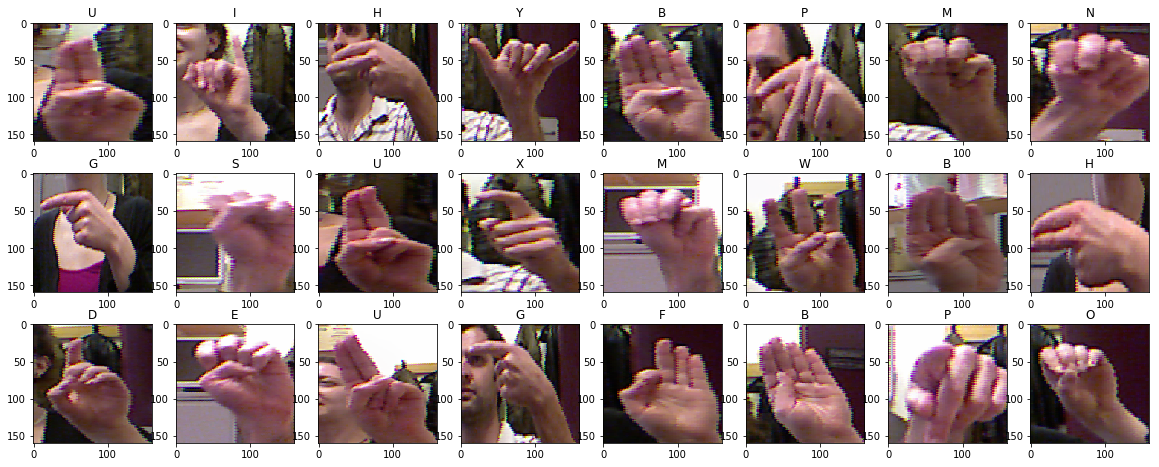

In [27]:
np.random.seed(8675309)
%matplotlib inline

# Display image previews below
plt.figure(figsize=(20,55))
columns = 8
n = 1

# Randomly choose images to display (with label)
for image_path in np.random.choice(train_data, 24, replace=False):
    img = Image.open(image_path)
    plt.subplot(20, columns, n)
    n+=1
    plt.imshow(img)
    letter = image_path.split('/')[-1][:2]
    letter = chr(int(letter)+65)
    plt.title(letter)

### Preparing the model

In [ ]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (224, 224, 1)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 1) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
valid_tensors = paths_to_tensor(valid_data).astype('float32')
test_tensors = paths_to_tensor(test_data).astype('float32')

In [ ]:
# Prepare training data separately since this is usually large
train_tensors = paths_to_tensor(train_data).astype('float32')

## Basic CNN model from scratch

### Building basic model

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
#Convo 224, 224, 1
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 1)))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(GlobalAveragePooling2D())
#Dense; 24 for each handshape 
model.add(Dense(24, activation='softmax'))


model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Training basic model

In [ ]:
from keras.callbacks import ModelCheckpoint  

epochs = 16

# Create a saved models directory
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath=f'{models_dir}/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

### Evaluating basic model

In [ ]:
handshape_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(handshape_predictions)==np.argmax(test_targets, axis=1))/len(handshape_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

## Transfer Learning with VGG16

### Preparing the model

In [ ]:
# Define image size to use for given model
n_pixels = 80
# Define a model name for records
model_name ='rgbModel_{}px'.format(n_pixels) if is_rgb else 'model_{}px'.format(n_pixels)

In [ ]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(n_pixels, n_pixels), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (n, n, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, n, n, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# Pre-process the data for Keras
# Prepare training data separately since this is usually large

print('Preparing to create valid tensors')
valid_tensors = paths_to_tensor(valid_data).astype('float32')
print('valid tensors prepared')

In [ ]:
print('Preparing to create test tensors')
test_tensors = paths_to_tensor(test_data).astype('float32')
print('test tensors prepared')

In [ ]:
print('Preparing to create train tensors')
train_tensors = paths_to_tensor(train_data).astype('float32')
print('train tensors prepared')

### Extract Bottleneck Features for Training Set

In [ ]:
# Name & path of bottleneck features
feat_train_name = 'vgg16_{}_features_train'.format(model_name)
feat_train_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_train_name)

# Load the data
targets = np.squeeze(train_targets)
print('data loaded')

# Load vgg16 model + remove final classification layers
model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(n_pixels, n_pixels, 3), classes=24)
print('model loaded')

# Obtain bottleneck features (train)
if os.path.exists(feat_train_path):
    print('bottleneck features detected (train)')
    features = np.load(feat_train_path)['features']
else:
    print('bottleneck features file not detected (train)')
    
    print('calculating now ...')
    # Pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(train_tensors[i], (n_pixels, n_pixels, 3)) 
                            for i in range(0, len(train_tensors))]).astype('float32')
    vgg16_input_train = vgg16.preprocess_input(big_x_train)
    print('train data preprocessed')
    
    # Extract, process, and save bottleneck features
    features = model.predict(vgg16_input_train)
    features = np.squeeze(features)
    np.savez(feat_train_path, features=features)

print('bottleneck features saved (train)')

### Extract Bottleneck Features for Validation Set

In [ ]:
# Name & path of bottleneck features
feat_valid_name = 'vgg16_{}_features_valid'.format(model_name)
feat_valid_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_valid_name)

# Obtain bottleneck features (valid)
if os.path.exists(feat_valid_path):
    print('bottleneck features detected (valid)')
    features_valid = np.load(feat_valid_path)['features_test']
else:
    # Calculating for validation set
    print('bottleneck features file not detected (valid)')
    print('calculating now ...')
    # Pre-process the valid data
    big_x_valid = np.array([scipy.misc.imresize(valid_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(valid_tensors))]).astype('float32')

    vgg16_input_valid = vgg16.preprocess_input(big_x_valid)
    # Extract, process, and save bottleneck features (valid)
    features_valid = model.predict(vgg16_input_valid)
    features_valid = np.squeeze(features_valid)
    np.savez(feat_valid_path, features_test=features_valid)
print('bottleneck features saved (valid)')

### Extract Bottleneck Features for Test Set

In [ ]:
# Name & path of bottleneck features
feat_test_name = 'vgg16_{}_features_test'.format(model_name)
feat_test_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_test_name)

# Obtain bottleneck features (test)
if os.path.exists(feat_test_path):
    print('bottleneck features detected (test)')
    features_test = np.load(feat_test_path)['features_test']
else:
    # Calculating for test set
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(test_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(test_tensors))]).astype('float32')

    vgg16_input_test = vgg16.preprocess_input(big_x_test)
    # Extract, process, and save bottleneck features (test)
    features_test = model.predict(vgg16_input_test)
    features_test = np.squeeze(features_test)
    np.savez(feat_test_path, features_test=features_test)
print('bottleneck features saved (test)')

### Building model

In [ ]:
features.shape
type(features)
features_ = features

In [ ]:
# 3 CNN Layers
model = Sequential()

model.add(Conv2D(filters=256, kernel_size=2, input_shape=features.shape[1:]))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128, kernel_size=1))

model.add(Conv2D(filters=32, kernel_size=1))
model.add(Dropout(0.3))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
epochs = 50
batchsize = 500
model_weights_path = '{}/vgg16_{}.best_batch{}_epoch{}.hdf5'.format(models_dir,model_name,batchsize,epochs)

checkpointer = ModelCheckpoint(filepath=model_weights_path, 
                               verbose=1, save_best_only=True)

model.fit(features, targets, batch_size=batchsize, epochs=epochs,
          validation_data=(features_valid, valid_targets),
          callbacks=[checkpointer],
          verbose=2, shuffle=True)          

### Evaluating the model

In [ ]:
# Load the weights that yielded the best validation accuracy
model.load_weights(model_weights_path)

# Evaluate test accuracy
score = model.evaluate(features_test, test_targets, verbose=0)
accuracy = 100*score[1]

# Print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

## Transfer Learning with VGG19

### Preparing the model

In [ ]:
# Define image size to use for given model
n_pixels = 160
# Define a model name for recorcs
model_name = 'model_{}px'.format(n_pixels)

In [ ]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(n_pixels, n_pixels), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (n, n, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, n, n, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# Pre-process the data for Keras
# Prepare training data separately since this is usually large

print('Preparing to create valid tensors')
valid_tensors = paths_to_tensor(valid_data).astype('float32')
print('valid tensors prepared')

In [ ]:
print('Preparing to create test tensors')
test_tensors = paths_to_tensor(test_data).astype('float32')
print('test tensors prepared')

In [ ]:
print('Preparing to create train tensors')
train_tensors = paths_to_tensor(train_data).astype('float32')
print('train tensors prepared')

### Extract Bottleneck Features for Training Set

In [ ]:
# Load the data
targets = np.squeeze(train_targets)
print('data loaded')

# Load vgg19 model + remove final classification layers
model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(n_pixels, n_pixels, 3), classes=24)
print('model loaded')

# Obtain bottleneck features (train)
if os.path.exists('vgg19_features_train.npz'):
    print('bottleneck features detected (train)')
    features = np.load('vgg19_features_train.npz')['features']
else:
    print('bottleneck features file not detected (train)')
    
    print('calculating now ...')
    # Pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(train_tensors[i], (n_pixels, n_pixels, 3)) 
                            for i in range(0, len(train_tensors))]).astype('float32')
    vgg19_input_train = vgg19.preprocess_input(big_x_train)
    print('train data preprocessed')
    
    # Extract, process, and save bottleneck features
    features = model.predict(vgg19_input_train)
    features = np.squeeze(features)
    np.savez('vgg19_features_train', features=features)

print('bottleneck features saved (train)')

### Extract Bottleneck Features for Validation Set

In [ ]:
# Obtain bottleneck features (valid)
if os.path.exists('vgg19_features_valid.npz'):
    print('bottleneck features detected (valid)')
    features_valid = np.load('vgg19_features_valid.npz')['features_test']
else:
    # Calculating for validation set
    print('bottleneck features file not detected (valid)')
    print('calculating now ...')
    # Pre-process the valid data
    big_x_valid = np.array([scipy.misc.imresize(valid_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(valid_tensors))]).astype('float32')

    vgg19_input_valid = vgg19.preprocess_input(big_x_valid)
    # Extract, process, and save bottleneck features (valid)
    features_valid = model.predict(vgg19_input_valid)
    features_valid = np.squeeze(features_valid)
    np.savez('vgg19_features_valid', features_test=features_valid)
print('bottleneck features saved (valid)')

### Extract Bottleneck Features for Test Set

In [ ]:
# Obtain bottleneck features (test)
if os.path.exists('vgg19_features_test.npz'):
    print('bottleneck features detected (test)')
    features_test = np.load('vgg19_features_test.npz')['features_test']
else:
    # Calculating for test set
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(test_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(test_tensors))]).astype('float32')

    vgg19_input_test = vgg19.preprocess_input(big_x_test)
    # Extract, process, and save bottleneck features (test)
    features_test = model.predict(vgg19_input_test)
    features_test = np.squeeze(features_test)
    np.savez('vgg19_features_test', features_test=features_test)
print('bottleneck features saved (test)')

### Building model

In [ ]:
features.shape

In [ ]:
# Shallow NN
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(filters=256, kernel_size=2, input_shape=features.shape[1:]))
model.add(Dropout(0.4))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



In [ ]:
epochs = 256
batchsize = 512
model_weights_path = f'{models_dir}/vgg19_new_{model_name}.best_batch{batchsize}_epoch{epochs}.hdf5'

checkpointer = ModelCheckpoint(filepath=model_weights_path, 
                               verbose=1, save_best_only=True)

model.fit(features, targets, batch_size=batchsize, epochs=epochs,
          validation_data=(features_valid, valid_targets),
          callbacks=[checkpointer],
          verbose=2, shuffle=True)          

### Evaluating the model

In [ ]:
# Load the weights that yielded the best validation accuracy
model.load_weights(model_weights_path)

# Evaluate test accuracy
score = model.evaluate(features_test, test_targets, verbose=0)
accuracy = 100*score[1]

# Print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

## Transfer Learning with ResNet50

### Preparing the model

In [4]:
# Define image size to use for given model
n_pixels = 197
# Define a model name for records
model_name ='rgbModel_{}px'.format(n_pixels) if is_rgb else 'model_{}px'.format(n_pixels)

In [5]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(n_pixels, n_pixels), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (n, n, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, n, n, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# Pre-process the data for Keras
# Prepare training data separately since this is usually large

print('Preparing to create valid tensors')
valid_tensors = paths_to_tensor(valid_data).astype('float32')
print('valid tensors prepared')

  1%|          | 69/10599 [00:00<00:15, 686.63it/s]

Preparing to create valid tensors


100%|██████████| 10599/10599 [00:16<00:00, 658.26it/s]


valid tensors prepared


In [13]:
print('Preparing to create test tensors')
test_tensors = paths_to_tensor(test_data).astype('float32')
print('test tensors prepared')

  0%|          | 58/12782 [00:00<00:22, 577.28it/s]

Preparing to create test tensors


100%|██████████| 12782/12782 [00:21<00:00, 594.40it/s]


test tensors prepared


In [12]:
print('Preparing to create train tensors')
train_tensors = paths_to_tensor(train_data).astype('float32')
print('train tensors prepared')

Preparing to create train tensors
train tensors prepared


### Extract Bottleneck Features for Training Set

In [7]:
# Name & path of bottleneck features
feat_train_name = 'resnet50_{}_features_train'.format(model_name)
feat_train_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_train_name)

# Load the data
targets = np.squeeze(train_targets)
print('data loaded')

# Load resnet50 model + remove final classification layers
model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(n_pixels, n_pixels, 3), classes=24)
print('model loaded')

# Obtain bottleneck features (train)
if os.path.exists(feat_train_path):
    print('bottleneck features detected (train)')
    features = np.load(feat_train_path)['features']
else:
    print('bottleneck features file not detected (train)')
    
    print('calculating now ...')
    # Pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(train_tensors[i], (n_pixels, n_pixels, 3)) 
                            for i in range(0, len(train_tensors))]).astype('float32')
    resnet50_input_train = resnet50.preprocess_input(big_x_train)
    print('train data preprocessed')
    
    # Extract, process, and save bottleneck features
    features = model.predict(resnet50_input_train)
#     features = np.squeeze(features)
    np.savez(feat_train_path, features=features)

print('bottleneck features saved (train)')

data loaded
model loaded
bottleneck features file not detected (train)
calculating now ...
train data preprocessed
bottleneck features saved (train)


### Extract Bottleneck Features for Validation Set

In [9]:
# Name & path of bottleneck features
feat_valid_name = 'resnet50_{}_features_valid'.format(model_name)
feat_valid_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_valid_name)

# Obtain bottleneck features (valid)
if os.path.exists(feat_valid_path):
    print('bottleneck features detected (valid)')
    features_valid = np.load(feat_valid_path)['features_test']
else:
    # Calculating for validation set
    print('bottleneck features file not detected (valid)')
    print('calculating now ...')
    # Pre-process the valid data
    big_x_valid = np.array([scipy.misc.imresize(valid_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(valid_tensors))]).astype('float32')

    resnet50_input_valid = resnet50.preprocess_input(big_x_valid)
    # Extract, process, and save bottleneck features (valid)
    features_valid = model.predict(resnet50_input_valid)
#     features_valid = np.squeeze(features_valid)
    np.savez(feat_valid_path, features_test=features_valid)
print('bottleneck features saved (valid)')

bottleneck features file not detected (valid)
calculating now ...
bottleneck features saved (valid)


### Extract Bottleneck Features for Test Set

In [14]:
# Name & path of bottleneck features
feat_test_name = 'resnet50_{}_features_test'.format(model_name)
feat_test_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_test_name)

# Obtain bottleneck features (test)
if os.path.exists(feat_test_path):
    print('bottleneck features detected (test)')
    features_test = np.load(feat_test_path)['features_test']
else:
    # Calculating for test set
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(test_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(test_tensors))]).astype('float32')

    resnet50_input_test = resnet50.preprocess_input(big_x_test)
    # Extract, process, and save bottleneck features (test)
    features_test = model.predict(resnet50_input_test)
#     features_test = np.squeeze(features_test)
    np.savez(feat_test_path, features_test=features_test)
print('bottleneck features saved (test)')

bottleneck features file not detected (test)
calculating now ...
bottleneck features saved (test)


### Building model

In [16]:
# 3 CNN Layers
model = Sequential()

model.add(Conv2D(filters=256, kernel_size=1, input_shape=features.shape[1:]))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128, kernel_size=1))

model.add(Conv2D(filters=32, kernel_size=1))
model.add(Dropout(0.3))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 1, 256)         524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 128)         32896     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 32)          4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
__________

In [36]:
epochs = 1024
batchsize = 512
model_details = 'resnet50_{}_batch{}_epoch{}'.format(model_name,batchsize,epochs)
model_weights_path = '{}/{}.hdf5'.format(models_dir,model_details)

checkpointer = ModelCheckpoint(filepath=model_weights_path, 
                               verbose=1, save_best_only=True)

model.fit(features, targets, batch_size=batchsize, epochs=epochs,
          validation_data=(features_valid, valid_targets),
          callbacks=[checkpointer],
          verbose=2, shuffle=True)          

Train on 42393 samples, validate on 10599 samples
Epoch 1/1024
Epoch 00000: val_loss improved from inf to 0.06933, saving model to saved_models/vgg16_rgbModel_197px.best_batch512_epoch1024.hdf5
0s - loss: 0.1456 - acc: 0.9500 - val_loss: 0.0693 - val_acc: 0.9773
Epoch 2/1024
Epoch 00001: val_loss did not improve
0s - loss: 0.1430 - acc: 0.9509 - val_loss: 0.0978 - val_acc: 0.9708
Epoch 3/1024
Epoch 00002: val_loss improved from 0.06933 to 0.06005, saving model to saved_models/vgg16_rgbModel_197px.best_batch512_epoch1024.hdf5
0s - loss: 0.1464 - acc: 0.9507 - val_loss: 0.0601 - val_acc: 0.9805
Epoch 4/1024
Epoch 00003: val_loss did not improve
0s - loss: 0.1433 - acc: 0.9502 - val_loss: 0.0882 - val_acc: 0.9713
Epoch 5/1024
Epoch 00004: val_loss did not improve
0s - loss: 0.1419 - acc: 0.9500 - val_loss: 0.0601 - val_acc: 0.9809
Epoch 6/1024
Epoch 00005: val_loss did not improve
0s - loss: 0.1413 - acc: 0.9507 - val_loss: 0.0702 - val_acc: 0.9776
Epoch 7/1024
Epoch 00006: val_loss did n

Epoch 00065: val_loss did not improve
0s - loss: 0.1284 - acc: 0.9559 - val_loss: 0.0760 - val_acc: 0.9774
Epoch 67/1024
Epoch 00066: val_loss did not improve
0s - loss: 0.1311 - acc: 0.9534 - val_loss: 0.0673 - val_acc: 0.9788
Epoch 68/1024
Epoch 00067: val_loss did not improve
0s - loss: 0.1200 - acc: 0.9570 - val_loss: 0.0748 - val_acc: 0.9758
Epoch 69/1024
Epoch 00068: val_loss improved from 0.04718 to 0.04640, saving model to saved_models/vgg16_rgbModel_197px.best_batch512_epoch1024.hdf5
0s - loss: 0.1285 - acc: 0.9546 - val_loss: 0.0464 - val_acc: 0.9848
Epoch 70/1024
Epoch 00069: val_loss did not improve
0s - loss: 0.1233 - acc: 0.9567 - val_loss: 0.0756 - val_acc: 0.9770
Epoch 71/1024
Epoch 00070: val_loss did not improve
0s - loss: 0.1270 - acc: 0.9551 - val_loss: 0.0526 - val_acc: 0.9832
Epoch 72/1024
Epoch 00071: val_loss did not improve
0s - loss: 0.1239 - acc: 0.9562 - val_loss: 0.0800 - val_acc: 0.9755
Epoch 73/1024
Epoch 00072: val_loss did not improve
0s - loss: 0.1232 

Epoch 00132: val_loss did not improve
0s - loss: 0.1112 - acc: 0.9610 - val_loss: 0.0513 - val_acc: 0.9847
Epoch 134/1024
Epoch 00133: val_loss did not improve
0s - loss: 0.1128 - acc: 0.9605 - val_loss: 0.0606 - val_acc: 0.9815
Epoch 135/1024
Epoch 00134: val_loss did not improve
0s - loss: 0.1164 - acc: 0.9591 - val_loss: 0.0577 - val_acc: 0.9808
Epoch 136/1024
Epoch 00135: val_loss did not improve
0s - loss: 0.1090 - acc: 0.9609 - val_loss: 0.0600 - val_acc: 0.9815
Epoch 137/1024
Epoch 00136: val_loss did not improve
0s - loss: 0.1102 - acc: 0.9607 - val_loss: 0.0693 - val_acc: 0.9778
Epoch 138/1024
Epoch 00137: val_loss did not improve
0s - loss: 0.1127 - acc: 0.9613 - val_loss: 0.0512 - val_acc: 0.9848
Epoch 139/1024
Epoch 00138: val_loss did not improve
0s - loss: 0.1109 - acc: 0.9611 - val_loss: 0.0674 - val_acc: 0.9782
Epoch 140/1024
Epoch 00139: val_loss did not improve
0s - loss: 0.1177 - acc: 0.9599 - val_loss: 0.0487 - val_acc: 0.9835
Epoch 141/1024
Epoch 00140: val_loss di

Epoch 00199: val_loss did not improve
0s - loss: 0.1044 - acc: 0.9642 - val_loss: 0.0581 - val_acc: 0.9814
Epoch 201/1024
Epoch 00200: val_loss did not improve
0s - loss: 0.0986 - acc: 0.9651 - val_loss: 0.0675 - val_acc: 0.9807
Epoch 202/1024
Epoch 00201: val_loss did not improve
0s - loss: 0.1051 - acc: 0.9645 - val_loss: 0.0733 - val_acc: 0.9787
Epoch 203/1024
Epoch 00202: val_loss did not improve
0s - loss: 0.1024 - acc: 0.9642 - val_loss: 0.0648 - val_acc: 0.9799
Epoch 204/1024
Epoch 00203: val_loss did not improve
0s - loss: 0.1005 - acc: 0.9645 - val_loss: 0.0522 - val_acc: 0.9831
Epoch 205/1024
Epoch 00204: val_loss did not improve
0s - loss: 0.1020 - acc: 0.9642 - val_loss: 0.0604 - val_acc: 0.9815
Epoch 206/1024
Epoch 00205: val_loss did not improve
0s - loss: 0.1013 - acc: 0.9647 - val_loss: 0.0938 - val_acc: 0.9723
Epoch 207/1024
Epoch 00206: val_loss did not improve
0s - loss: 0.1008 - acc: 0.9655 - val_loss: 0.0640 - val_acc: 0.9794
Epoch 208/1024
Epoch 00207: val_loss di

Epoch 00266: val_loss did not improve
0s - loss: 0.0976 - acc: 0.9660 - val_loss: 0.0707 - val_acc: 0.9776
Epoch 268/1024
Epoch 00267: val_loss did not improve
0s - loss: 0.0974 - acc: 0.9656 - val_loss: 0.0816 - val_acc: 0.9754
Epoch 269/1024
Epoch 00268: val_loss did not improve
0s - loss: 0.0922 - acc: 0.9672 - val_loss: 0.0534 - val_acc: 0.9840
Epoch 270/1024
Epoch 00269: val_loss did not improve
0s - loss: 0.0993 - acc: 0.9652 - val_loss: 0.0697 - val_acc: 0.9804
Epoch 271/1024
Epoch 00270: val_loss did not improve
0s - loss: 0.0934 - acc: 0.9674 - val_loss: 0.0664 - val_acc: 0.9815
Epoch 272/1024
Epoch 00271: val_loss did not improve
0s - loss: 0.0952 - acc: 0.9658 - val_loss: 0.0802 - val_acc: 0.9772
Epoch 273/1024
Epoch 00272: val_loss did not improve
0s - loss: 0.0951 - acc: 0.9663 - val_loss: 0.0567 - val_acc: 0.9823
Epoch 274/1024
Epoch 00273: val_loss did not improve
0s - loss: 0.0961 - acc: 0.9664 - val_loss: 0.0568 - val_acc: 0.9824
Epoch 275/1024
Epoch 00274: val_loss di

Epoch 00333: val_loss did not improve
0s - loss: 0.0905 - acc: 0.9684 - val_loss: 0.0634 - val_acc: 0.9808
Epoch 335/1024
Epoch 00334: val_loss did not improve
0s - loss: 0.0915 - acc: 0.9675 - val_loss: 0.0591 - val_acc: 0.9829
Epoch 336/1024
Epoch 00335: val_loss did not improve
0s - loss: 0.0902 - acc: 0.9685 - val_loss: 0.0510 - val_acc: 0.9845
Epoch 337/1024
Epoch 00336: val_loss did not improve
0s - loss: 0.0893 - acc: 0.9678 - val_loss: 0.0618 - val_acc: 0.9816
Epoch 338/1024
Epoch 00337: val_loss did not improve
0s - loss: 0.0888 - acc: 0.9689 - val_loss: 0.0459 - val_acc: 0.9861
Epoch 339/1024
Epoch 00338: val_loss did not improve
0s - loss: 0.0902 - acc: 0.9682 - val_loss: 0.0494 - val_acc: 0.9853
Epoch 340/1024
Epoch 00339: val_loss did not improve
0s - loss: 0.0895 - acc: 0.9692 - val_loss: 0.0670 - val_acc: 0.9810
Epoch 341/1024
Epoch 00340: val_loss did not improve
0s - loss: 0.0936 - acc: 0.9667 - val_loss: 0.0577 - val_acc: 0.9819
Epoch 342/1024
Epoch 00341: val_loss di

Epoch 00400: val_loss did not improve
0s - loss: 0.0887 - acc: 0.9686 - val_loss: 0.0664 - val_acc: 0.9811
Epoch 402/1024
Epoch 00401: val_loss did not improve
0s - loss: 0.0903 - acc: 0.9689 - val_loss: 0.0470 - val_acc: 0.9863
Epoch 403/1024
Epoch 00402: val_loss did not improve
0s - loss: 0.0879 - acc: 0.9697 - val_loss: 0.0485 - val_acc: 0.9856
Epoch 404/1024
Epoch 00403: val_loss did not improve
0s - loss: 0.0877 - acc: 0.9690 - val_loss: 0.0535 - val_acc: 0.9838
Epoch 405/1024
Epoch 00404: val_loss did not improve
0s - loss: 0.0822 - acc: 0.9705 - val_loss: 0.0448 - val_acc: 0.9863
Epoch 406/1024
Epoch 00405: val_loss did not improve
0s - loss: 0.0854 - acc: 0.9704 - val_loss: 0.0653 - val_acc: 0.9825
Epoch 407/1024
Epoch 00406: val_loss did not improve
0s - loss: 0.0854 - acc: 0.9701 - val_loss: 0.0490 - val_acc: 0.9850
Epoch 408/1024
Epoch 00407: val_loss did not improve
0s - loss: 0.0877 - acc: 0.9701 - val_loss: 0.0503 - val_acc: 0.9858
Epoch 409/1024
Epoch 00408: val_loss di

Epoch 00468: val_loss did not improve
0s - loss: 0.0825 - acc: 0.9716 - val_loss: 0.0478 - val_acc: 0.9865
Epoch 470/1024
Epoch 00469: val_loss did not improve
0s - loss: 0.0825 - acc: 0.9713 - val_loss: 0.0449 - val_acc: 0.9861
Epoch 471/1024
Epoch 00470: val_loss did not improve
0s - loss: 0.0829 - acc: 0.9703 - val_loss: 0.0558 - val_acc: 0.9828
Epoch 472/1024
Epoch 00471: val_loss did not improve
0s - loss: 0.0835 - acc: 0.9711 - val_loss: 0.0661 - val_acc: 0.9810
Epoch 473/1024
Epoch 00472: val_loss did not improve
0s - loss: 0.0814 - acc: 0.9717 - val_loss: 0.0491 - val_acc: 0.9850
Epoch 474/1024
Epoch 00473: val_loss did not improve
0s - loss: 0.0811 - acc: 0.9707 - val_loss: 0.0514 - val_acc: 0.9855
Epoch 475/1024
Epoch 00474: val_loss did not improve
0s - loss: 0.0822 - acc: 0.9704 - val_loss: 0.0463 - val_acc: 0.9864
Epoch 476/1024
Epoch 00475: val_loss did not improve
0s - loss: 0.0834 - acc: 0.9706 - val_loss: 0.0467 - val_acc: 0.9858
Epoch 477/1024
Epoch 00476: val_loss di

Epoch 00536: val_loss did not improve
0s - loss: 0.0834 - acc: 0.9704 - val_loss: 0.0494 - val_acc: 0.9857
Epoch 538/1024
Epoch 00537: val_loss did not improve
0s - loss: 0.0774 - acc: 0.9720 - val_loss: 0.0532 - val_acc: 0.9858
Epoch 539/1024
Epoch 00538: val_loss did not improve
0s - loss: 0.0848 - acc: 0.9705 - val_loss: 0.0435 - val_acc: 0.9868
Epoch 540/1024
Epoch 00539: val_loss did not improve
0s - loss: 0.0787 - acc: 0.9721 - val_loss: 0.0628 - val_acc: 0.9825
Epoch 541/1024
Epoch 00540: val_loss did not improve
0s - loss: 0.0820 - acc: 0.9706 - val_loss: 0.0584 - val_acc: 0.9831
Epoch 542/1024
Epoch 00541: val_loss did not improve
0s - loss: 0.0783 - acc: 0.9715 - val_loss: 0.0489 - val_acc: 0.9852
Epoch 543/1024
Epoch 00542: val_loss did not improve
0s - loss: 0.0804 - acc: 0.9714 - val_loss: 0.0478 - val_acc: 0.9864
Epoch 544/1024
Epoch 00543: val_loss did not improve
0s - loss: 0.0784 - acc: 0.9719 - val_loss: 0.0593 - val_acc: 0.9835
Epoch 545/1024
Epoch 00544: val_loss di

Epoch 00604: val_loss did not improve
0s - loss: 0.0792 - acc: 0.9715 - val_loss: 0.0524 - val_acc: 0.9861
Epoch 606/1024
Epoch 00605: val_loss did not improve
0s - loss: 0.0806 - acc: 0.9720 - val_loss: 0.0539 - val_acc: 0.9846
Epoch 607/1024
Epoch 00606: val_loss did not improve
0s - loss: 0.0738 - acc: 0.9741 - val_loss: 0.0503 - val_acc: 0.9857
Epoch 608/1024
Epoch 00607: val_loss did not improve
0s - loss: 0.0814 - acc: 0.9721 - val_loss: 0.0478 - val_acc: 0.9858
Epoch 609/1024
Epoch 00608: val_loss did not improve
0s - loss: 0.0797 - acc: 0.9716 - val_loss: 0.0577 - val_acc: 0.9835
Epoch 610/1024
Epoch 00609: val_loss did not improve
0s - loss: 0.0784 - acc: 0.9725 - val_loss: 0.0551 - val_acc: 0.9852
Epoch 611/1024
Epoch 00610: val_loss did not improve
0s - loss: 0.0788 - acc: 0.9725 - val_loss: 0.0490 - val_acc: 0.9849
Epoch 612/1024
Epoch 00611: val_loss did not improve
0s - loss: 0.0824 - acc: 0.9713 - val_loss: 0.0478 - val_acc: 0.9851
Epoch 613/1024
Epoch 00612: val_loss di

Epoch 00672: val_loss did not improve
0s - loss: 0.0768 - acc: 0.9734 - val_loss: 0.0503 - val_acc: 0.9848
Epoch 674/1024
Epoch 00673: val_loss did not improve
0s - loss: 0.0758 - acc: 0.9737 - val_loss: 0.0626 - val_acc: 0.9823
Epoch 675/1024
Epoch 00674: val_loss did not improve
0s - loss: 0.0758 - acc: 0.9733 - val_loss: 0.0514 - val_acc: 0.9856
Epoch 676/1024
Epoch 00675: val_loss did not improve
0s - loss: 0.0758 - acc: 0.9736 - val_loss: 0.0512 - val_acc: 0.9846
Epoch 677/1024
Epoch 00676: val_loss did not improve
0s - loss: 0.0755 - acc: 0.9727 - val_loss: 0.0477 - val_acc: 0.9860
Epoch 678/1024
Epoch 00677: val_loss did not improve
0s - loss: 0.0727 - acc: 0.9741 - val_loss: 0.0605 - val_acc: 0.9828
Epoch 679/1024
Epoch 00678: val_loss did not improve
0s - loss: 0.0764 - acc: 0.9723 - val_loss: 0.0463 - val_acc: 0.9859
Epoch 680/1024
Epoch 00679: val_loss did not improve
0s - loss: 0.0758 - acc: 0.9729 - val_loss: 0.0488 - val_acc: 0.9852
Epoch 681/1024
Epoch 00680: val_loss di

Epoch 00740: val_loss did not improve
0s - loss: 0.0732 - acc: 0.9733 - val_loss: 0.0530 - val_acc: 0.9853
Epoch 742/1024
Epoch 00741: val_loss did not improve
0s - loss: 0.0745 - acc: 0.9737 - val_loss: 0.0466 - val_acc: 0.9871
Epoch 743/1024
Epoch 00742: val_loss did not improve
0s - loss: 0.0780 - acc: 0.9728 - val_loss: 0.0464 - val_acc: 0.9858
Epoch 744/1024
Epoch 00743: val_loss did not improve
0s - loss: 0.0728 - acc: 0.9741 - val_loss: 0.0607 - val_acc: 0.9844
Epoch 745/1024
Epoch 00744: val_loss did not improve
0s - loss: 0.0737 - acc: 0.9736 - val_loss: 0.0527 - val_acc: 0.9858
Epoch 746/1024
Epoch 00745: val_loss did not improve
0s - loss: 0.0768 - acc: 0.9729 - val_loss: 0.0526 - val_acc: 0.9850
Epoch 747/1024
Epoch 00746: val_loss did not improve
0s - loss: 0.0755 - acc: 0.9728 - val_loss: 0.0658 - val_acc: 0.9827
Epoch 748/1024
Epoch 00747: val_loss did not improve
0s - loss: 0.0748 - acc: 0.9738 - val_loss: 0.0527 - val_acc: 0.9851
Epoch 749/1024
Epoch 00748: val_loss di

Epoch 00808: val_loss did not improve
0s - loss: 0.0739 - acc: 0.9734 - val_loss: 0.0432 - val_acc: 0.9864
Epoch 810/1024
Epoch 00809: val_loss did not improve
0s - loss: 0.0722 - acc: 0.9745 - val_loss: 0.0616 - val_acc: 0.9834
Epoch 811/1024
Epoch 00810: val_loss did not improve
0s - loss: 0.0703 - acc: 0.9749 - val_loss: 0.0551 - val_acc: 0.9851
Epoch 812/1024
Epoch 00811: val_loss did not improve
0s - loss: 0.0745 - acc: 0.9737 - val_loss: 0.0602 - val_acc: 0.9823
Epoch 813/1024
Epoch 00812: val_loss did not improve
0s - loss: 0.0700 - acc: 0.9749 - val_loss: 0.0485 - val_acc: 0.9860
Epoch 814/1024
Epoch 00813: val_loss did not improve
0s - loss: 0.0711 - acc: 0.9745 - val_loss: 0.0466 - val_acc: 0.9863
Epoch 815/1024
Epoch 00814: val_loss did not improve
0s - loss: 0.0742 - acc: 0.9733 - val_loss: 0.0483 - val_acc: 0.9856
Epoch 816/1024
Epoch 00815: val_loss did not improve
0s - loss: 0.0718 - acc: 0.9752 - val_loss: 0.0494 - val_acc: 0.9856
Epoch 817/1024
Epoch 00816: val_loss di

Epoch 00876: val_loss did not improve
0s - loss: 0.0699 - acc: 0.9758 - val_loss: 0.0600 - val_acc: 0.9841
Epoch 878/1024
Epoch 00877: val_loss did not improve
0s - loss: 0.0727 - acc: 0.9747 - val_loss: 0.0608 - val_acc: 0.9836
Epoch 879/1024
Epoch 00878: val_loss did not improve
0s - loss: 0.0756 - acc: 0.9747 - val_loss: 0.0592 - val_acc: 0.9850
Epoch 880/1024
Epoch 00879: val_loss did not improve
0s - loss: 0.0736 - acc: 0.9738 - val_loss: 0.0485 - val_acc: 0.9858
Epoch 881/1024
Epoch 00880: val_loss did not improve
0s - loss: 0.0697 - acc: 0.9753 - val_loss: 0.0656 - val_acc: 0.9818
Epoch 882/1024
Epoch 00881: val_loss did not improve
0s - loss: 0.0734 - acc: 0.9736 - val_loss: 0.0469 - val_acc: 0.9853
Epoch 883/1024
Epoch 00882: val_loss did not improve
0s - loss: 0.0697 - acc: 0.9757 - val_loss: 0.0559 - val_acc: 0.9847
Epoch 884/1024
Epoch 00883: val_loss did not improve
0s - loss: 0.0693 - acc: 0.9746 - val_loss: 0.0568 - val_acc: 0.9841
Epoch 885/1024
Epoch 00884: val_loss di

Epoch 00944: val_loss did not improve
0s - loss: 0.0739 - acc: 0.9739 - val_loss: 0.0580 - val_acc: 0.9833
Epoch 946/1024
Epoch 00945: val_loss did not improve
0s - loss: 0.0707 - acc: 0.9750 - val_loss: 0.0554 - val_acc: 0.9840
Epoch 947/1024
Epoch 00946: val_loss did not improve
0s - loss: 0.0700 - acc: 0.9749 - val_loss: 0.0479 - val_acc: 0.9861
Epoch 948/1024
Epoch 00947: val_loss did not improve
0s - loss: 0.0730 - acc: 0.9739 - val_loss: 0.0573 - val_acc: 0.9844
Epoch 949/1024
Epoch 00948: val_loss did not improve
0s - loss: 0.0703 - acc: 0.9750 - val_loss: 0.0522 - val_acc: 0.9853
Epoch 950/1024
Epoch 00949: val_loss did not improve
0s - loss: 0.0725 - acc: 0.9739 - val_loss: 0.0553 - val_acc: 0.9846
Epoch 951/1024
Epoch 00950: val_loss did not improve
0s - loss: 0.0691 - acc: 0.9761 - val_loss: 0.0509 - val_acc: 0.9853
Epoch 952/1024
Epoch 00951: val_loss did not improve
0s - loss: 0.0709 - acc: 0.9756 - val_loss: 0.0512 - val_acc: 0.9861
Epoch 953/1024
Epoch 00952: val_loss di

Epoch 01012: val_loss did not improve
0s - loss: 0.0724 - acc: 0.9746 - val_loss: 0.0591 - val_acc: 0.9831
Epoch 1014/1024
Epoch 01013: val_loss did not improve
0s - loss: 0.0691 - acc: 0.9766 - val_loss: 0.0550 - val_acc: 0.9854
Epoch 1015/1024
Epoch 01014: val_loss did not improve
0s - loss: 0.0721 - acc: 0.9742 - val_loss: 0.0555 - val_acc: 0.9858
Epoch 1016/1024
Epoch 01015: val_loss did not improve
0s - loss: 0.0720 - acc: 0.9745 - val_loss: 0.0513 - val_acc: 0.9841
Epoch 1017/1024
Epoch 01016: val_loss did not improve
0s - loss: 0.0710 - acc: 0.9748 - val_loss: 0.0471 - val_acc: 0.9871
Epoch 1018/1024
Epoch 01017: val_loss did not improve
0s - loss: 0.0666 - acc: 0.9770 - val_loss: 0.0498 - val_acc: 0.9854
Epoch 1019/1024
Epoch 01018: val_loss did not improve
0s - loss: 0.0683 - acc: 0.9758 - val_loss: 0.0512 - val_acc: 0.9859
Epoch 1020/1024
Epoch 01019: val_loss did not improve
0s - loss: 0.0705 - acc: 0.9755 - val_loss: 0.0552 - val_acc: 0.9853
Epoch 1021/1024
Epoch 01020: val

### Evaluating the model

In [37]:
# Load the weights that yielded the best validation accuracy
model.load_weights(model_weights_path)

# Evaluate test accuracy
score = model.evaluate(features_test, test_targets, verbose=0)
accuracy = 100*score[1]

# Print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 70.3098%


## Confusion Matrix of Test Data

After performing tests, a confusion matrix can be used to evaluate the model and it's accuracy for each ASL handshape/letter. Below we use the weight's from the last model defined and used above to generate our confusion matrix.

In [38]:
# Load the weights of 
# model_weights_path = 'saved_models/vgg16_rgbModel_100px.best_batch500_epoch150.hdf5'
model.load_weights(model_weights_path)

test_predictions = model.predict_classes(features_test)

12288/12782 [===========================>..] - ETA: 0s

In [39]:
sess = tf.Session()
# Change one-hot encoding to just an integer representing letter
un_hot_encode_targets = np.argmax(test_targets, axis=1)

confusion_arr = sess.run(tf.confusion_matrix(un_hot_encode_targets, test_predictions, 24))
# Get percents to compare with research paper benchmark
confusion_arr_percents = confusion_arr/sum(confusion_arr)

In [40]:
# Note no 'J' & 'Z' were used
letters = "ABCDEFGHIKLMNOPQRSTUVWXY"

# Print out counts to see distribution of the number of letters tested against
for elem in ['{}: {}'.format(letter,count) for letter,count in zip(letters,sum(confusion_arr))]:
    print(elem)

A: 560
B: 559
C: 514
D: 453
E: 798
F: 465
G: 831
H: 155
I: 480
K: 477
L: 558
M: 366
N: 1419
O: 355
P: 454
Q: 196
R: 483
S: 519
T: 311
U: 784
V: 739
W: 513
X: 327
Y: 466


In [41]:
# Save confusion matrix/array as CSVs for reference
np.savetxt('confusion_matrices/confusionMatrix_{}_counts.csv'.format(model_details),confusion_arr)
np.savetxt('confusion_matrices/confusionMatrix_{}_percent.csv'.format(model_details),confusion_arr_percents)

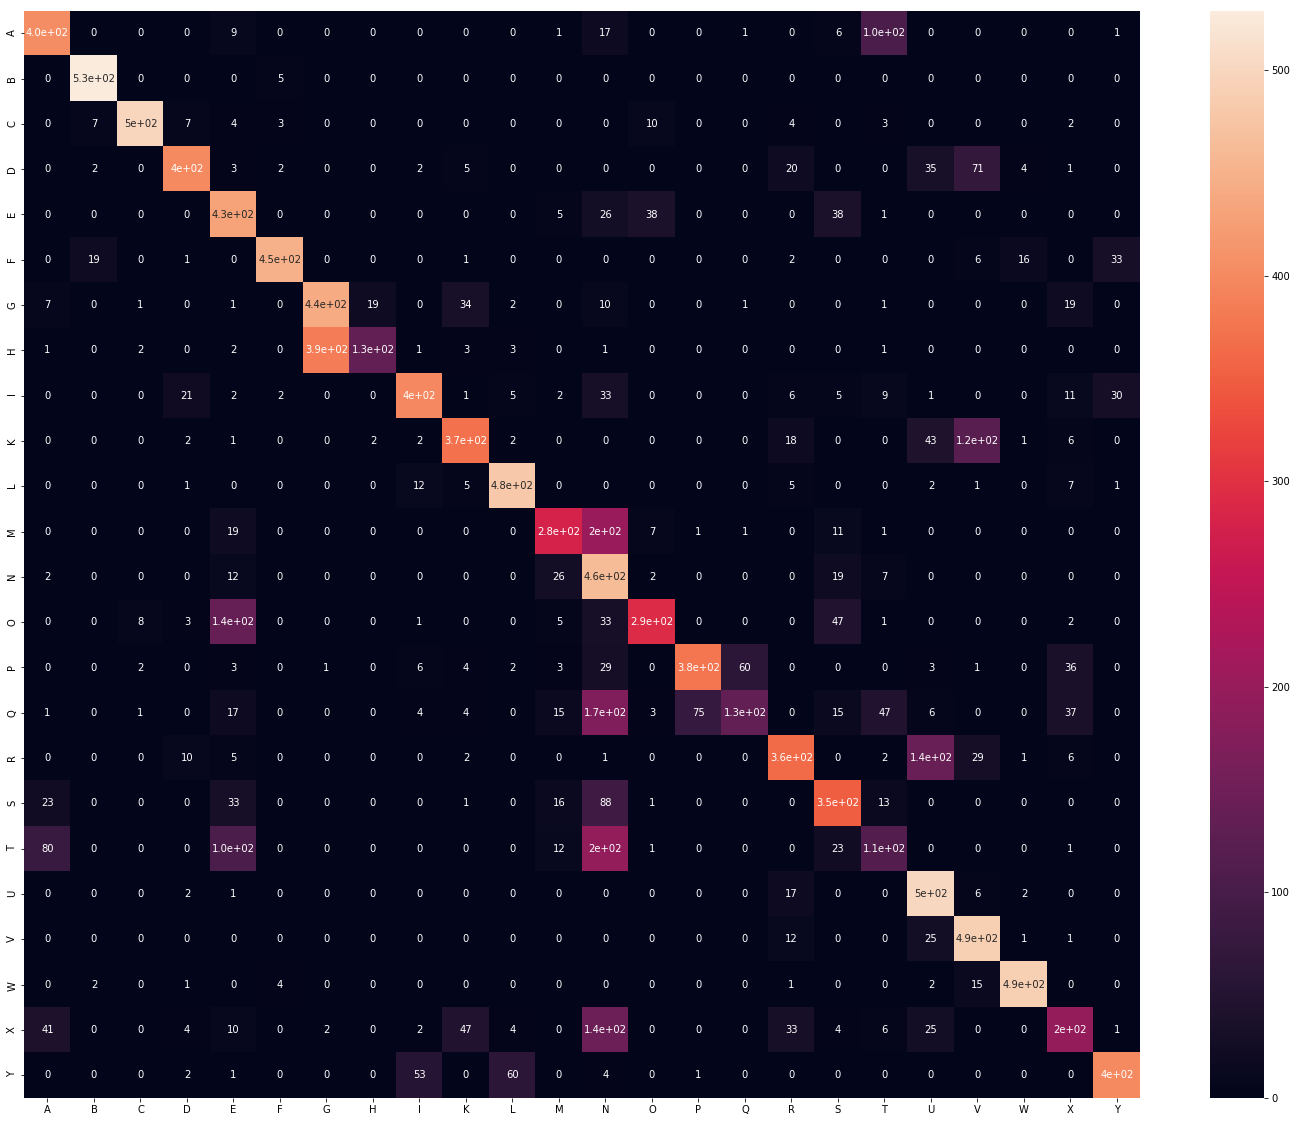

In [42]:
df_cm = pd.DataFrame(confusion_arr, index = [i for i in letters],
                  columns = [i for i in letters])
plt.figure(figsize = (25,20))
sn.heatmap(df_cm, annot=True)

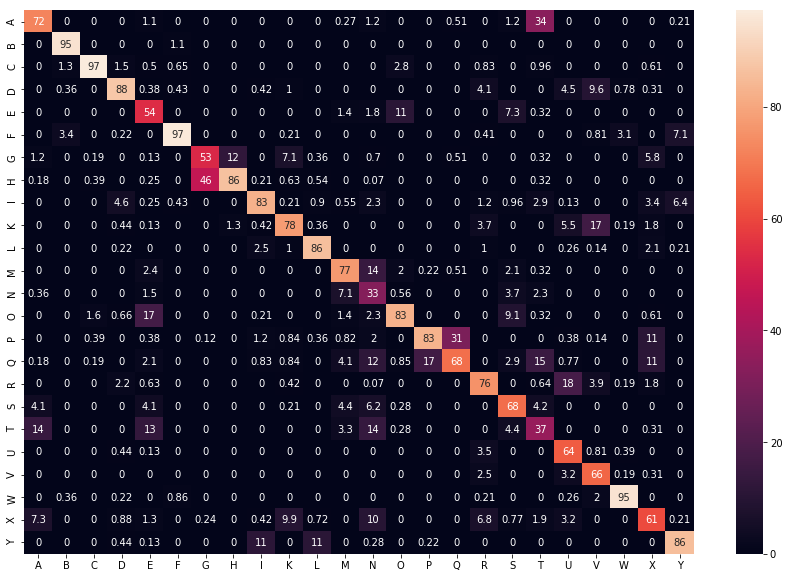

In [43]:
# Percentages for confusion matrix
# Multiplied by 100 to make it easier to read values
df_cm = pd.DataFrame(confusion_arr_percents*100, index = [i for i in letters],
                  columns = [i for i in letters])
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True)